# RPC Transfer Time-Series Analysis

This notebook visualizes RPC transfer timing (latency and bandwidth) over time during BenchFS benchmark runs.

## Data Source
- `rpc_transfer_raw.csv`: Raw per-transfer timing data
- `rpc_transfer_aggregated.csv`: Aggregated by time interval, node, and operation

## Key Metrics
- **elapsed_us**: RPC call latency in microseconds (includes data transfer)
- **bandwidth_mib_s**: Effective bandwidth in MiB/s
- **op**: Operation type (READ or WRITE)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from datetime import datetime

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

# Configure plot sizes
plt.rcParams['figure.figsize'] = [14, 8]
plt.rcParams['font.size'] = 12

In [2]:
# Load the raw CSV
# Update this path to your results directory
RESULTS_DIR = Path('../results/benchfs/2026.01.23-14.36.23-debug_large/2026.01.23-14.42.23-540469.nqsv-16')

csv_path = RESULTS_DIR / 'rpc_transfer_raw.csv'
if not csv_path.exists():
    print(f"CSV not found at {csv_path}")
    print("Please run extract_rpc_transfer_csv.sh first:")
    print(f"  ./jobs/benchfs/extract_rpc_transfer_csv.sh {RESULTS_DIR} --aggregate 1")
else:
    df = pd.read_csv(csv_path)
    print(f"Loaded {len(df)} records")
    print(f"Columns: {list(df.columns)}")
    df.head()

Loaded 3060640 records
Columns: ['timestamp', 'client_node', 'op', 'target_node', 'bytes', 'elapsed_us', 'bandwidth_mib_s']


In [3]:
# Parse timestamps and add relative time
def parse_timestamp(ts_str):
    """Parse ISO timestamp string to datetime."""
    try:
        ts_str = ts_str.replace('Z', '+00:00')
        return datetime.fromisoformat(ts_str)
    except:
        return None

df['datetime'] = df['timestamp'].apply(parse_timestamp)
df = df.dropna(subset=['datetime'])

# Calculate relative time in seconds from start
start_time = df['datetime'].min()
df['time_relative'] = (df['datetime'] - start_time).dt.total_seconds()

# Convert bytes to MiB
df['bytes_mib'] = df['bytes'] / (1024 * 1024)

# Convert elapsed_us to ms for readability
df['elapsed_ms'] = df['elapsed_us'] / 1000

# Basic statistics
print(f"Time range: {df['datetime'].min()} - {df['datetime'].max()}")
print(f"Duration: {df['time_relative'].max():.1f} seconds")
print(f"Operations: {df['op'].unique()}")
print(f"Client nodes: {sorted(df['client_node'].unique())}")
print(f"\nCounts by operation:")
print(df['op'].value_counts())

Time range: 2026-01-23 05:45:05.234927+00:00 - 2026-01-23 05:49:23.001975+00:00
Duration: 257.8 seconds
Operations: ['WRITE' 'READ']
Client nodes: ['bnode029', 'bnode031', 'bnode034', 'bnode036', 'bnode038', 'bnode039', 'bnode058', 'bnode062', 'bnode080', 'bnode081', 'bnode082', 'bnode092', 'bnode094', 'bnode100', 'bnode109', 'bnode126']

Counts by operation:
op
WRITE    2766268
READ      294372
Name: count, dtype: int64


## 1. Latency Distribution by Operation

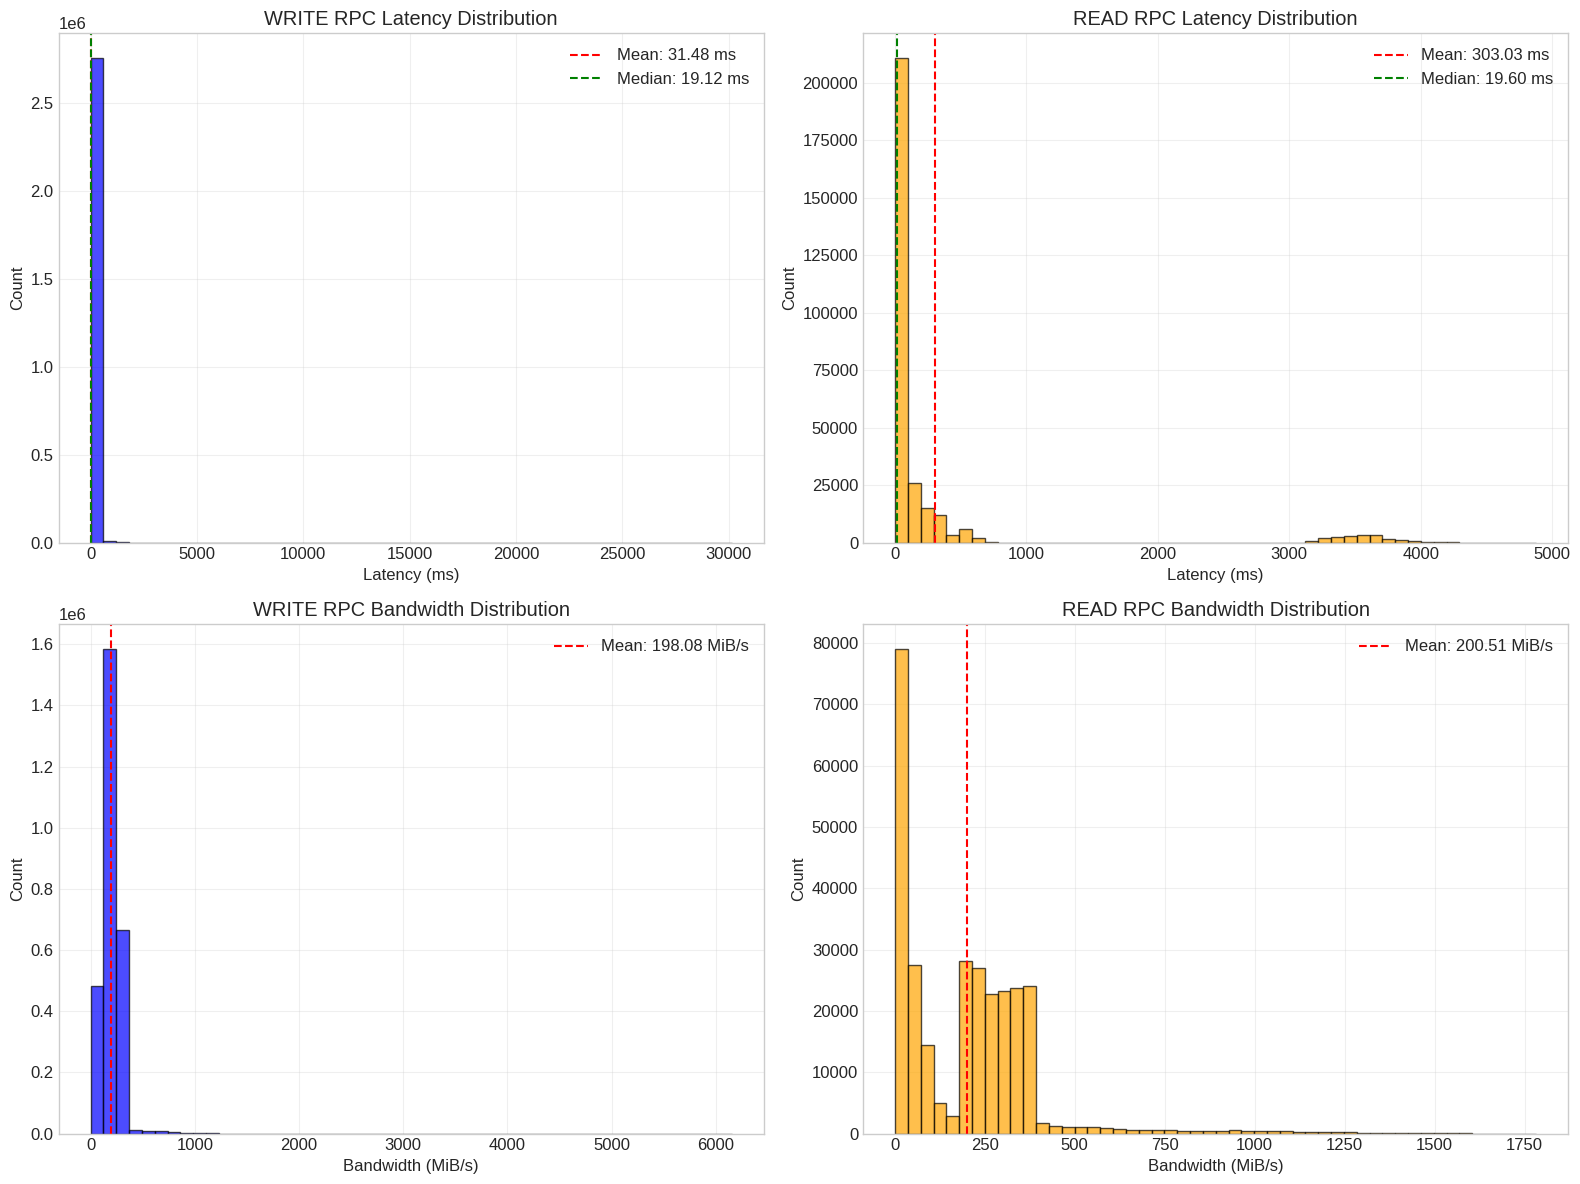


=== WRITE Statistics ===
  Count: 2,766,268
  Latency (ms): mean=31.48, median=19.12, p95=86.86, p99=151.01
  Bandwidth (MiB/s): mean=198.08, median=209.18

=== READ Statistics ===
  Count: 294,372
  Latency (ms): mean=303.03, median=19.60, p95=3368.08, p99=3794.59
  Bandwidth (MiB/s): mean=200.51, median=204.10

=== Comparison ===
  READ/WRITE latency ratio: 9.63x
  WRITE/READ bandwidth ratio: 0.99x


In [4]:
# Separate WRITE and READ
df_write = df[df['op'] == 'WRITE']
df_read = df[df['op'] == 'READ']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Latency histogram - WRITE
ax = axes[0, 0]
if len(df_write) > 0:
    ax.hist(df_write['elapsed_ms'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(df_write['elapsed_ms'].mean(), color='red', linestyle='--', label=f"Mean: {df_write['elapsed_ms'].mean():.2f} ms")
    ax.axvline(df_write['elapsed_ms'].median(), color='green', linestyle='--', label=f"Median: {df_write['elapsed_ms'].median():.2f} ms")
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Count')
    ax.set_title('WRITE RPC Latency Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Latency histogram - READ
ax = axes[0, 1]
if len(df_read) > 0:
    ax.hist(df_read['elapsed_ms'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax.axvline(df_read['elapsed_ms'].mean(), color='red', linestyle='--', label=f"Mean: {df_read['elapsed_ms'].mean():.2f} ms")
    ax.axvline(df_read['elapsed_ms'].median(), color='green', linestyle='--', label=f"Median: {df_read['elapsed_ms'].median():.2f} ms")
    ax.set_xlabel('Latency (ms)')
    ax.set_ylabel('Count')
    ax.set_title('READ RPC Latency Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Bandwidth histogram - WRITE
ax = axes[1, 0]
if len(df_write) > 0:
    ax.hist(df_write['bandwidth_mib_s'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(df_write['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_write['bandwidth_mib_s'].mean():.2f} MiB/s")
    ax.set_xlabel('Bandwidth (MiB/s)')
    ax.set_ylabel('Count')
    ax.set_title('WRITE RPC Bandwidth Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Bandwidth histogram - READ
ax = axes[1, 1]
if len(df_read) > 0:
    ax.hist(df_read['bandwidth_mib_s'], bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax.axvline(df_read['bandwidth_mib_s'].mean(), color='red', linestyle='--', label=f"Mean: {df_read['bandwidth_mib_s'].mean():.2f} MiB/s")
    ax.set_xlabel('Bandwidth (MiB/s)')
    ax.set_ylabel('Count')
    ax.set_title('READ RPC Bandwidth Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rpc_transfer_distribution.png', dpi=150)
plt.show()

# Print statistics
print("\n=== WRITE Statistics ===")
if len(df_write) > 0:
    print(f"  Count: {len(df_write):,}")
    print(f"  Latency (ms): mean={df_write['elapsed_ms'].mean():.2f}, median={df_write['elapsed_ms'].median():.2f}, p95={df_write['elapsed_ms'].quantile(0.95):.2f}, p99={df_write['elapsed_ms'].quantile(0.99):.2f}")
    print(f"  Bandwidth (MiB/s): mean={df_write['bandwidth_mib_s'].mean():.2f}, median={df_write['bandwidth_mib_s'].median():.2f}")

print("\n=== READ Statistics ===")
if len(df_read) > 0:
    print(f"  Count: {len(df_read):,}")
    print(f"  Latency (ms): mean={df_read['elapsed_ms'].mean():.2f}, median={df_read['elapsed_ms'].median():.2f}, p95={df_read['elapsed_ms'].quantile(0.95):.2f}, p99={df_read['elapsed_ms'].quantile(0.99):.2f}")
    print(f"  Bandwidth (MiB/s): mean={df_read['bandwidth_mib_s'].mean():.2f}, median={df_read['bandwidth_mib_s'].median():.2f}")

if len(df_write) > 0 and len(df_read) > 0:
    print(f"\n=== Comparison ===")
    print(f"  READ/WRITE latency ratio: {df_read['elapsed_ms'].mean() / df_write['elapsed_ms'].mean():.2f}x")
    print(f"  WRITE/READ bandwidth ratio: {df_write['bandwidth_mib_s'].mean() / df_read['bandwidth_mib_s'].mean():.2f}x")

## 2. Latency Over Time

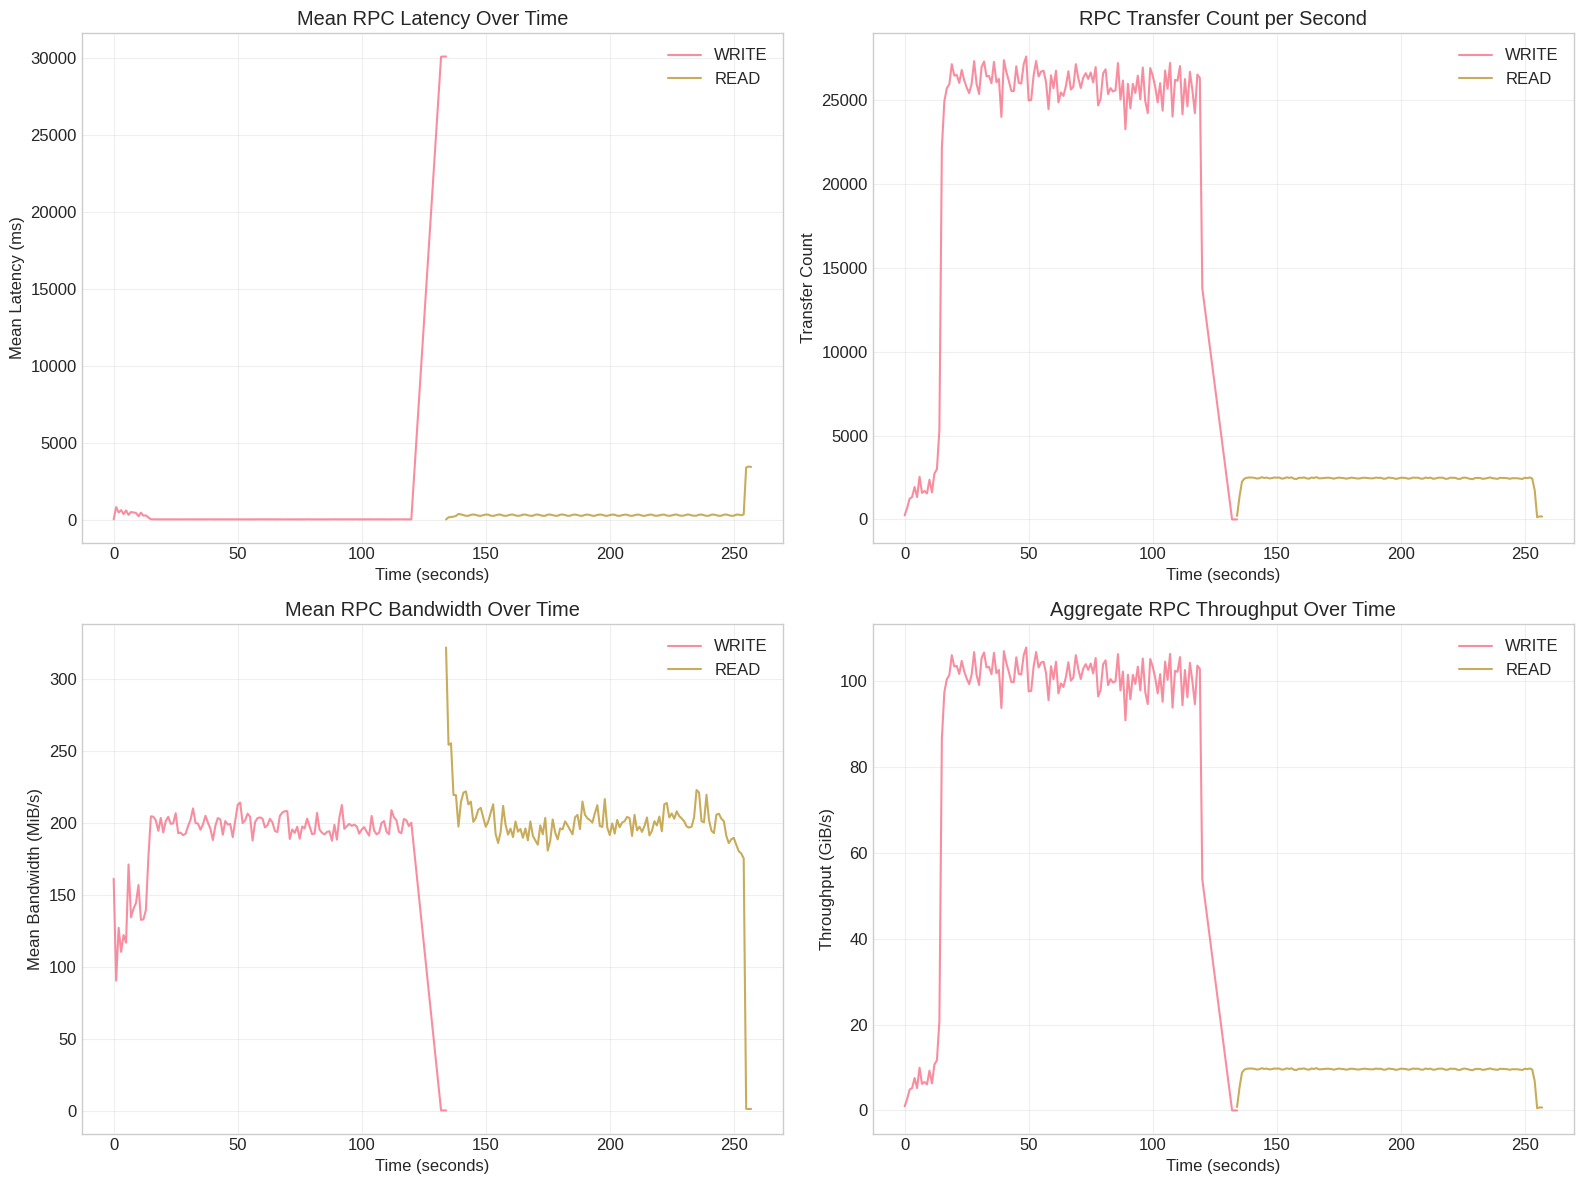

In [5]:
# Aggregate by time bucket (1 second)
time_bucket = 1  # seconds
df['time_bucket'] = (df['time_relative'] // time_bucket).astype(int) * time_bucket

# Calculate statistics per time bucket and operation
time_stats = df.groupby(['time_bucket', 'op']).agg({
    'elapsed_ms': ['mean', 'median', 'min', 'max', 'std', 'count'],
    'bandwidth_mib_s': ['mean', 'median'],
    'bytes': 'sum'
}).reset_index()
time_stats.columns = ['time', 'op', 'latency_mean', 'latency_median', 'latency_min', 'latency_max', 'latency_std', 'count', 'bw_mean', 'bw_median', 'total_bytes']
time_stats['throughput_gib_s'] = time_stats['total_bytes'] / (1024**3) / time_bucket

write_stats = time_stats[time_stats['op'] == 'WRITE']
read_stats = time_stats[time_stats['op'] == 'READ']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Mean latency over time
ax = axes[0, 0]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['latency_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['latency_mean'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Mean Latency (ms)')
ax.set_title('Mean RPC Latency Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Transfer count over time
ax = axes[0, 1]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['count'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['count'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Transfer Count')
ax.set_title('RPC Transfer Count per Second')
ax.legend()
ax.grid(True, alpha=0.3)

# Mean bandwidth over time
ax = axes[1, 0]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['bw_mean'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['bw_mean'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Mean Bandwidth (MiB/s)')
ax.set_title('Mean RPC Bandwidth Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# Aggregate throughput over time
ax = axes[1, 1]
if len(write_stats) > 0:
    ax.plot(write_stats['time'], write_stats['throughput_gib_s'], label='WRITE', linewidth=1.5, alpha=0.8)
if len(read_stats) > 0:
    ax.plot(read_stats['time'], read_stats['throughput_gib_s'], label='READ', linewidth=1.5, alpha=0.8)
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Throughput (GiB/s)')
ax.set_title('Aggregate RPC Throughput Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rpc_transfer_over_time.png', dpi=150)
plt.show()

## 3. Latency Range Over Time

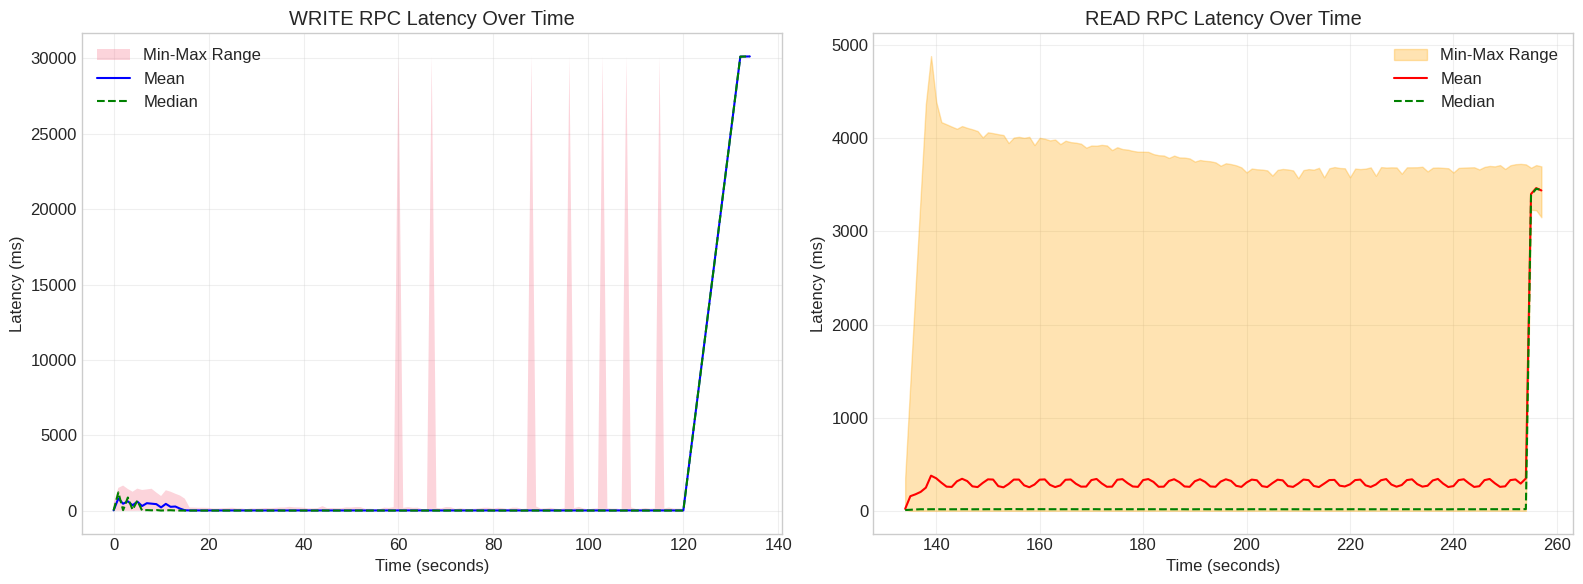

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# WRITE latency with min-max range
ax = axes[0]
if len(write_stats) > 0:
    ax.fill_between(write_stats['time'], write_stats['latency_min'], write_stats['latency_max'], alpha=0.3, label='Min-Max Range')
    ax.plot(write_stats['time'], write_stats['latency_mean'], linewidth=1.5, label='Mean', color='blue')
    ax.plot(write_stats['time'], write_stats['latency_median'], linewidth=1.5, label='Median', color='green', linestyle='--')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Latency (ms)')
ax.set_title('WRITE RPC Latency Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

# READ latency with min-max range
ax = axes[1]
if len(read_stats) > 0:
    ax.fill_between(read_stats['time'], read_stats['latency_min'], read_stats['latency_max'], alpha=0.3, color='orange', label='Min-Max Range')
    ax.plot(read_stats['time'], read_stats['latency_mean'], linewidth=1.5, label='Mean', color='red')
    ax.plot(read_stats['time'], read_stats['latency_median'], linewidth=1.5, label='Median', color='green', linestyle='--')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Latency (ms)')
ax.set_title('READ RPC Latency Over Time')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rpc_transfer_latency_range.png', dpi=150)
plt.show()

## 4. Per-Client Analysis

Per-Client Statistics:
client_node    op  latency_mean  latency_median  latency_std  count    bw_mean  bw_median  total_bytes  total_gib
   bnode029  READ    308.077845         19.5670   877.029379  17918 202.014567    204.430  75153539072  69.992188
   bnode029 WRITE     31.631525         19.1885    64.808104 171994 196.625691    208.455 721395122176 671.851562
   bnode031  READ    301.789603         19.4875   866.672102  18300 200.017330    205.260  76755763200  71.484375
   bnode031 WRITE     31.725478         19.2040    65.344963 171458 196.339889    208.290 719146975232 669.757812
   bnode034  READ    302.099065         19.5750   859.149651  18439 199.141438    204.340  77338771456  72.027344
   bnode034 WRITE     31.831793         19.2340    97.910905 170975 195.969326    207.970 717121126400 667.871094
   bnode036  READ    302.505325         19.4745   860.646758  18446 201.539338    205.395  77368131584  72.054688
   bnode036 WRITE     31.560920         19.2270    63.547466 1722

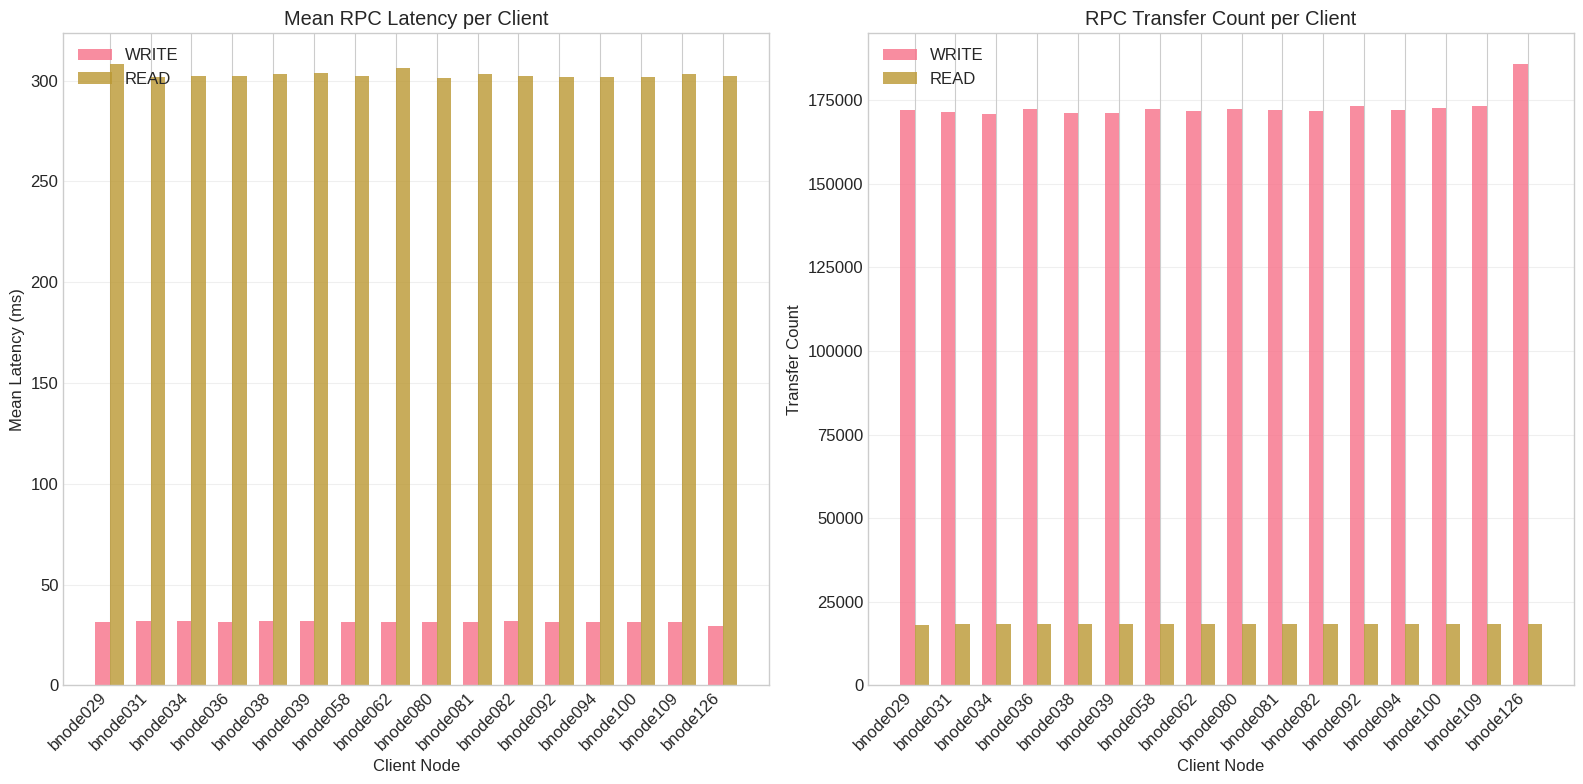

In [7]:
# Per-client statistics
client_stats = df.groupby(['client_node', 'op']).agg({
    'elapsed_ms': ['mean', 'median', 'std', 'count'],
    'bandwidth_mib_s': ['mean', 'median'],
    'bytes': 'sum'
}).reset_index()
client_stats.columns = ['client_node', 'op', 'latency_mean', 'latency_median', 'latency_std', 'count', 'bw_mean', 'bw_median', 'total_bytes']
client_stats['total_gib'] = client_stats['total_bytes'] / (1024**3)

print("Per-Client Statistics:")
print(client_stats.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Mean latency per client by op
ax = axes[0]
client_write = client_stats[client_stats['op'] == 'WRITE'].sort_values('client_node')
client_read = client_stats[client_stats['op'] == 'READ'].sort_values('client_node')

x = np.arange(len(client_write))
width = 0.35

if len(client_write) > 0:
    ax.bar(x - width/2, client_write['latency_mean'], width, label='WRITE', alpha=0.8)
if len(client_read) > 0:
    ax.bar(x + width/2, client_read['latency_mean'], width, label='READ', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(client_write['client_node'] if len(client_write) > 0 else client_read['client_node'], rotation=45, ha='right')
ax.set_xlabel('Client Node')
ax.set_ylabel('Mean Latency (ms)')
ax.set_title('Mean RPC Latency per Client')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Transfer count per client by op
ax = axes[1]
if len(client_write) > 0:
    ax.bar(x - width/2, client_write['count'], width, label='WRITE', alpha=0.8)
if len(client_read) > 0:
    ax.bar(x + width/2, client_read['count'], width, label='READ', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(client_write['client_node'] if len(client_write) > 0 else client_read['client_node'], rotation=45, ha='right')
ax.set_xlabel('Client Node')
ax.set_ylabel('Transfer Count')
ax.set_title('RPC Transfer Count per Client')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'rpc_transfer_per_client.png', dpi=150)
plt.show()

## 5. Latency Heatmap

In [8]:
# Heatmap: latency distribution over time
time_bin = 5  # seconds
df['time_bin'] = (df['time_relative'] // time_bin).astype(int) * time_bin

# Create latency buckets (log scale)
latency_bins = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000]
latency_labels = ['0-1ms', '1-2ms', '2-5ms', '5-10ms', '10-20ms', '20-50ms', '50-100ms', '100-200ms', '200-500ms', '500-1000ms', '>1000ms']

def create_latency_heatmap(data, title, filename):
    if len(data) == 0:
        print(f"No data for {title}")
        return
    
    heatmap_data = []
    for time_bin_val in sorted(data['time_bin'].unique()):
        bin_df = data[data['time_bin'] == time_bin_val]
        row = {'time': time_bin_val}
        for i in range(len(latency_bins) - 1):
            lo, hi = latency_bins[i], latency_bins[i+1]
            count = len(bin_df[(bin_df['elapsed_ms'] >= lo) & (bin_df['elapsed_ms'] < hi)])
            row[latency_labels[i]] = count
        heatmap_data.append(row)
    
    heatmap_df = pd.DataFrame(heatmap_data).set_index('time')
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    im = ax.imshow(heatmap_df.T, aspect='auto', cmap='YlOrRd',
                   extent=[heatmap_df.index.min(), heatmap_df.index.max(), 
                           len(heatmap_df.columns)-0.5, -0.5])
    
    ax.set_xlabel(f'Time (seconds, {time_bin}s bins)')
    ax.set_ylabel('Latency Range')
    ax.set_title(title)
    ax.set_yticks(range(len(heatmap_df.columns)))
    ax.set_yticklabels(heatmap_df.columns)
    
    cbar = plt.colorbar(im, ax=ax, label='Count')
    
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / filename, dpi=150)
    plt.show()

create_latency_heatmap(df_write, 'WRITE RPC Latency Distribution Over Time', 'rpc_write_latency_heatmap.png')
create_latency_heatmap(df_read, 'READ RPC Latency Distribution Over Time', 'rpc_read_latency_heatmap.png')

KeyError: 'time_bin'

## 6. Performance Analysis

In [ ]:
print("=" * 80)
print("RPC Transfer Performance Analysis")
print("=" * 80)

print(f"\nSource: {RESULTS_DIR}")
print(f"Total transfer events: {len(df):,}")
print(f"Duration: {df['time_relative'].max():.1f} seconds")

for op, op_df in [('WRITE', df_write), ('READ', df_read)]:
    if len(op_df) == 0:
        continue
    
    print(f"\n=== {op} Operations ===")
    print(f"  Count: {len(op_df):,}")
    print(f"  Total bytes: {op_df['bytes'].sum() / (1024**3):.2f} GiB")
    
    print(f"\n  Latency (ms):")
    print(f"    Mean:   {op_df['elapsed_ms'].mean():.2f}")
    print(f"    Median: {op_df['elapsed_ms'].median():.2f}")
    print(f"    Min:    {op_df['elapsed_ms'].min():.2f}")
    print(f"    Max:    {op_df['elapsed_ms'].max():.2f}")
    print(f"    Std:    {op_df['elapsed_ms'].std():.2f}")
    
    print(f"\n  Percentiles:")
    for p in [50, 90, 95, 99]:
        val = op_df['elapsed_ms'].quantile(p/100)
        print(f"    P{p}: {val:.2f} ms")
    
    print(f"\n  Bandwidth (MiB/s):")
    print(f"    Mean:   {op_df['bandwidth_mib_s'].mean():.2f}")
    print(f"    Median: {op_df['bandwidth_mib_s'].median():.2f}")
    
    # Time efficiency analysis
    total_time_sec = op_df['time_relative'].max() - op_df['time_relative'].min()
    if total_time_sec > 0:
        throughput = op_df['bytes'].sum() / (1024**3) / total_time_sec
        transfers_per_sec = len(op_df) / total_time_sec
        print(f"\n  Throughput:")
        print(f"    Aggregate: {throughput:.2f} GiB/s")
        print(f"    Transfers/sec: {transfers_per_sec:.2f}")

if len(df_write) > 0 and len(df_read) > 0:
    print("\n" + "=" * 80)
    print("Performance Comparison")
    print("=" * 80)
    
    write_avg_latency = df_write['elapsed_ms'].mean()
    read_avg_latency = df_read['elapsed_ms'].mean()
    write_avg_bw = df_write['bandwidth_mib_s'].mean()
    read_avg_bw = df_read['bandwidth_mib_s'].mean()
    
    print(f"\nLatency:")
    print(f"  WRITE: {write_avg_latency:.2f} ms")
    print(f"  READ:  {read_avg_latency:.2f} ms")
    print(f"  Ratio (READ/WRITE): {read_avg_latency/write_avg_latency:.2f}x")
    
    print(f"\nBandwidth:")
    print(f"  WRITE: {write_avg_bw:.2f} MiB/s")
    print(f"  READ:  {read_avg_bw:.2f} MiB/s")
    print(f"  Ratio (WRITE/READ): {write_avg_bw/read_avg_bw:.2f}x")
    
    print(f"\nTransfer count:")
    print(f"  WRITE: {len(df_write):,}")
    print(f"  READ:  {len(df_read):,}")
    print(f"  Ratio (WRITE/READ): {len(df_write)/len(df_read):.2f}x")
    
    if read_avg_latency > write_avg_latency * 2:
        print("\n" + "*" * 80)
        print(f"*** WARNING: READ latency is {read_avg_latency/write_avg_latency:.1f}x higher than WRITE ***")
        print("This suggests the RPC response path (server-side or data receive) is a bottleneck.")
        print("*" * 80)

## 7. Summary

In [ ]:
# Final summary and diagnosis
print("=" * 80)
print("Diagnosis")
print("=" * 80)

if len(df_write) > 0 and len(df_read) > 0:
    write_throughput = df_write['bytes'].sum() / (1024**3) / max(df_write['time_relative'].max() - df_write['time_relative'].min(), 1)
    read_throughput = df_read['bytes'].sum() / (1024**3) / max(df_read['time_relative'].max() - df_read['time_relative'].min(), 1)
    
    write_latency = df_write['elapsed_ms'].mean()
    read_latency = df_read['elapsed_ms'].mean()
    
    write_count_per_sec = len(df_write) / max(df_write['time_relative'].max() - df_write['time_relative'].min(), 1)
    read_count_per_sec = len(df_read) / max(df_read['time_relative'].max() - df_read['time_relative'].min(), 1)
    
    print(f"\nWRITE:")
    print(f"  Throughput: {write_throughput:.2f} GiB/s")
    print(f"  Avg latency: {write_latency:.2f} ms")
    print(f"  Transfers/sec: {write_count_per_sec:.0f}")
    
    print(f"\nREAD:")
    print(f"  Throughput: {read_throughput:.2f} GiB/s")
    print(f"  Avg latency: {read_latency:.2f} ms")
    print(f"  Transfers/sec: {read_count_per_sec:.0f}")
    
    if read_count_per_sec < write_count_per_sec * 0.5:
        print("\n*** ISSUE DETECTED: READ transfers/sec is much lower than WRITE ***")
        print("This indicates RPC concurrency is limited for READ operations.")
        print("Possible causes:")
        print("  - Server-side I/O blocking (sync file open, sync read)")
        print("  - Client-side response processing bottleneck")
        print("  - io_depth=1 issue (check io_depth analysis)")
    
    if read_latency > write_latency * 3:
        print("\n*** ISSUE DETECTED: READ latency is much higher than WRITE ***")
        print("This indicates the server-side READ path is slow.")
        print("Possible causes:")
        print("  - Synchronous file open on server")
        print("  - Page cache misses on server")
        print("  - Disk I/O contention")
else:
    print("Insufficient data for diagnosis.")